# Visualize Data from online simulation session
EEGNet was run with offline data being streamed in through BCI RasPy to simulate real-time data. This notebook will visualize the output of the decoder when feed in this offline data.

In [1]:
# import necesary modules
import numpy as np
import pickle
import tqdm
import data.data_util as util
from preprocessing import parse_labels, partition_data, augment_data, load_bci_competition, load_data
import matplotlib.pyplot as plt

In [2]:
# load in the data
data_fname = 'online_simulation_bm'  # name of the data file

fpath = "data/" + data_fname
eeg_data = util.load_data(fpath + "/eeg.bin")      # reads EEG data
eeg_data['databuffer'] = eeg_data['databuffer'][:, 0:64]  # removes channels 65 and 66
task_data = util.load_data(fpath + "/task.bin")# reads task data

In [3]:
task_data.keys()

dict_keys(['state_task', 'decoder_output', 'decoded_pos', 'eeg_step', 'time_ns', 'name', 'labels', 'dtypes'])

In [17]:
# print the data fields
print("EEG data fields:", eeg_data.keys())
print("Task data fields:", task_data.keys())

EEG data fields: dict_keys(['eegbuffersignal', 'databuffer', 'task_step', 'time_ns', 'name', 'labels', 'dtypes'])
Task data fields: dict_keys(['state_task', 'decoder_output', 'decoded_pos', 'eeg_step', 'time_ns', 'name', 'labels', 'dtypes'])


# Display the output of the decoder

In [18]:
task_data['decoder_output'].shape

(73576, 2)

Text(0.5, 0, 'Time Steps')

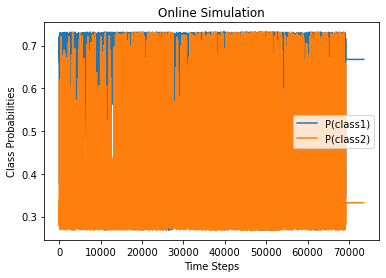

In [19]:
n_classes = task_data['decoder_output'].shape[-1]
for class_ix in range(n_classes):
    plt.plot(task_data['decoder_output'][:, class_ix])
plt.legend(['P(class1)', 'P(class2)', 'P(class3)', 'P(class4)'])
plt.title("Online Simulation")
plt.ylabel("Class Probabilities")
plt.xlabel("Time Steps")

Text(0.5, 0, 'Time Steps')

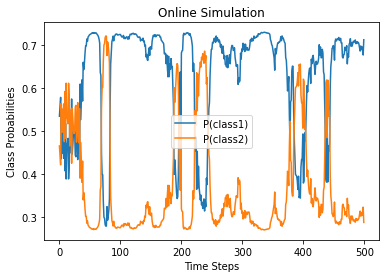

In [20]:
# now lets take a zoomed in look at timesteps 10,000
n_classes = task_data['decoder_output'].shape[-1]
for class_ix in range(n_classes):
    plt.plot(task_data['decoder_output'][10000:10500, class_ix])
plt.legend(['P(class1)', 'P(class2)', 'P(class3)', 'P(class4)'])
plt.title("Online Simulation")
plt.ylabel("Class Probabilities")
plt.xlabel("Time Steps")

Text(0.5, 0, 'Time Steps')

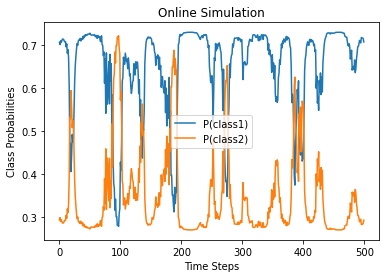

In [21]:
n_classes = task_data['decoder_output'].shape[-1]
for class_ix in range(n_classes):
    plt.plot(task_data['decoder_output'][12000:12500, class_ix])
plt.legend(['P(class1)', 'P(class2)', 'P(class3)', 'P(class4)'])
plt.title("Online Simulation")
plt.ylabel("Class Probabilities")
plt.xlabel("Time Steps")

Text(0.5, 0, 'Time Steps')

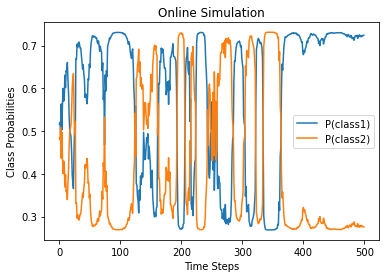

In [22]:
n_classes = task_data['decoder_output'].shape[-1]
for class_ix in range(n_classes):
    plt.plot(task_data['decoder_output'][50000:50500, class_ix])
plt.legend(['P(class1)', 'P(class2)', 'P(class3)', 'P(class4)'])
plt.title("Online Simulation")
plt.ylabel("Class Probabilities")
plt.xlabel("Time Steps")

Text(0.5, 0, 'Time Steps')

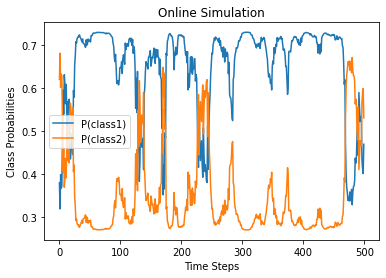

In [23]:
n_classes = task_data['decoder_output'].shape[-1]
for class_ix in range(n_classes):
    plt.plot(task_data['decoder_output'][60000:60500, class_ix])
plt.legend(['P(class1)', 'P(class2)', 'P(class3)', 'P(class4)'])
plt.title("Online Simulation")
plt.ylabel("Class Probabilities")
plt.xlabel("Time Steps")

# Now lets visualize the position drawn on the screen by the decoder during online simulation

In [24]:
task_data['decoded_pos'].shape

(73576, 2)

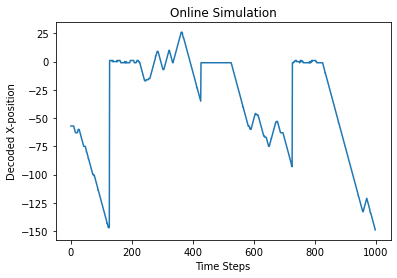

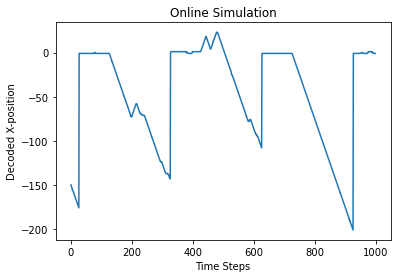

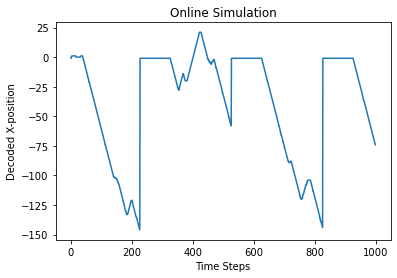

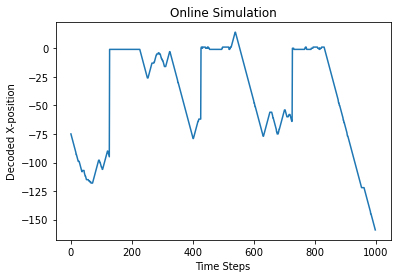

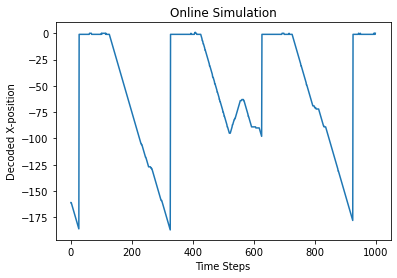

In [31]:
n_classes = task_data['decoded_pos'].shape[-1]

window_size = 1000
for i in range(5):
    plt.figure()
    plt.plot(task_data['decoded_pos'][50000+i*window_size:50000+(i+1)*window_size, 0])
    plt.title("Online Simulation")
    plt.ylabel("Decoded X-position")
    plt.xlabel("Time Steps")

### Notes on decoding performance

The task runs at 20ms ticks. Since the cue presentation lasts 4 seconds this corresponds to timestesp roughly 200 timesteps for ~4 seconds of data (slight variation due to timing violations).

Also, there is still a bias to the left but there is at least some dynamic movemen of the decoder to the left and the right. I am going to try to supress decoded output during the first 1 second of the cue presentation. I think the decoder may learn a bias towards left and right and since there isn't likely much useful information the first second after the cue is presented this initial bias may dominate the decoding result for the remainder of the trial.

I have subsequently improved some of the timing violations by placing more computations on the GPU. There are still timing violations that occur every few (approx 10) steps but they aren't as severe as before (occured at every step before). For now this is Ok but it may need further debuging if it occurs during online (non-simulated) experiments. I have also implemented a ~1 second delay before the decoder output gets drawn to prevent strong biasing of trials by initial second of data.

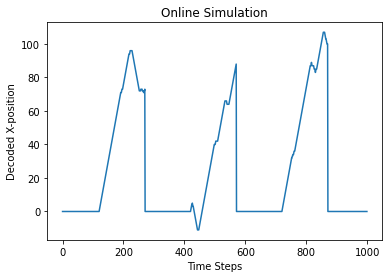

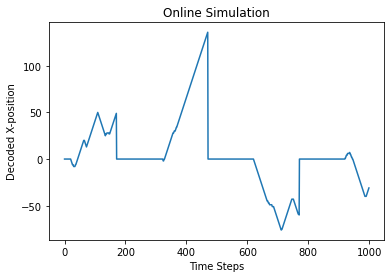

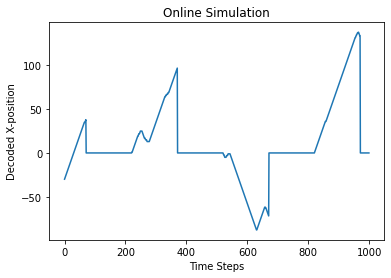

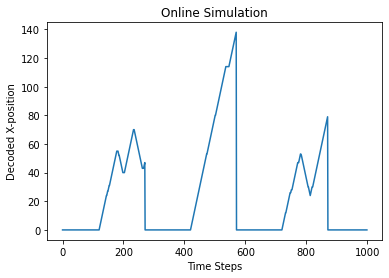

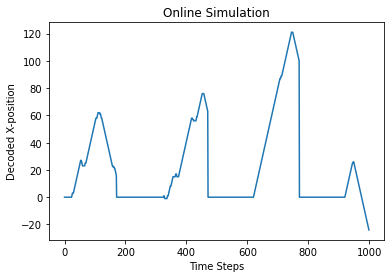

In [2]:
# load in the data
data_fname = 'online_simulation_bm_2'  # name of the data file

fpath = "data/" + data_fname
eeg_data = util.load_data(fpath + "/eeg.bin")      # reads EEG data
eeg_data['databuffer'] = eeg_data['databuffer'][:, 0:64]  # removes channels 65 and 66
task_data = util.load_data(fpath + "/task.bin")# reads task data

n_classes = task_data['decoded_pos'].shape[-1]

window_size = 1000
for i in range(5):
    plt.figure()
    plt.plot(task_data['decoded_pos'][50000+i*window_size:50000+(i+1)*window_size, 0])
    plt.title("Online Simulation")
    plt.ylabel("Decoded X-position")
    plt.xlabel("Time Steps")

## Average Decoded position during left v. right reach trials

In [13]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from pytorch_EEGNet import EEGNet
import pickle
import tqdm
import pdb
import data.data_util as util
from torch.optim.lr_scheduler import ReduceLROnPlateau
import tqdm

eeg_trials = []; eeg_trial_labels = []; decoder_trials = []
min_trial_len = 0
data_fname = 'online_simulation_bm_feedback'  # name of the data file

class_names={}
class_names[0] = "left"
class_names[1] = "right"
class_names[4] = "rest"

fpath = "data/" + data_fname
eeg_data = util.load_data(fpath + "/eeg.bin")      # reads EEG data
#eeg_data['databuffer'] = eeg_data['databuffer'][:, 0:64]  # removes channels 65 and 66
task_data = util.load_data(fpath + "/task.bin")# reads task data
    


In [14]:

# extract trial start times
new_state_bool = np.zeros(task_data['state_task'].size, dtype='bool')
new_state_bool[1:] = (task_data['state_task'][1:] != task_data['state_task'][:-1])
new_state_inds = np.nonzero(new_state_bool)[0]
trial_labels = task_data['state_task'][new_state_inds]
trial_start_times = task_data['time_ns'][new_state_inds] 
eeg_timing = eeg_data['time_ns']
task_timing = task_data['time_ns']


In [15]:
trial_start_times[5]

1632894723442361267

EEG timing shape: (1253569,)
Task timing shape: (63680,)


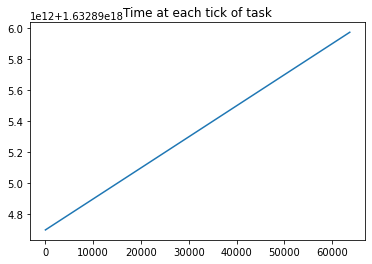

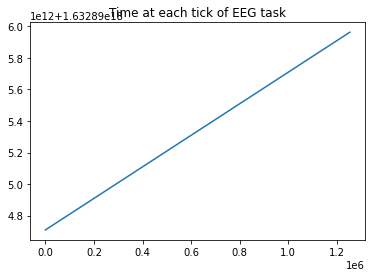

In [16]:
plt.figure()
plt.plot(task_timing)
plt.title("Time at each tick of task")

plt.figure()
plt.plot(eeg_timing)
plt.title("Time at each tick of EEG task")

print("EEG timing shape:", eeg_timing.shape)
print("Task timing shape:", task_timing.shape)


In [17]:
len(trial_start_times)

420

In [18]:
len(trial_labels)

420

In [19]:
np.where(eeg_timing > trial_start_times[len(trial_labels)-7])[0]

array([1243395, 1243396, 1243397, ..., 1253566, 1253567, 1253568],
      dtype=int64)

In [20]:
# partition trials
        
for trial_ix in range(len(trial_labels)-7):  # last seven trials don't exist in EEG data
    if int(trial_labels[trial_ix]) == 4:  # skip rest trials
        continue 

    # extract eeg_data indices were trial started and ended
    trial_start_ix = np.where(eeg_timing > trial_start_times[trial_ix])[0][0]
    trial_end_ix = np.where(eeg_timing < trial_start_times[trial_ix+1])[0][-1]

    # append data from 64 electrodes
    eeg_trials.append(eeg_data['databuffer'][trial_start_ix:trial_end_ix, :64])
    min_trial_len = np.minimum(eeg_trials[-1].shape[0], min_trial_len).astype(int)
    eeg_trial_labels.append(class_names[trial_labels[trial_ix]])

    # extract eeg_data indices were each decoder trial started and ended
    trial_start_ix = np.where(task_timing > trial_start_times[trial_ix])[0][0]
    trial_end_ix = np.where(task_timing < trial_start_times[trial_ix+1])[0][-1]

    # append data from 64 electrodes
    decoder_trials.append(task_data['decoded_pos'][trial_start_ix:trial_end_ix, 0])  # 0 only considers x position




In [21]:
# clip all trials
trial_duration = min_trial_len - 100 # omits the first 100ms of data
for trial_ix in range(len(eeg_trials)):
    eeg_trials[trial_ix] = eeg_trials[trial_ix][-trial_duration:,:]

eeg_trials = np.expand_dims(np.array(eeg_trials), axis=-1)
eeg_trials = eeg_trials.transpose(0,2,1,3)
eeg_trial_labels = np.array(eeg_trial_labels)
#return eeg_trials, eeg_trial_labels, decoder_trials

C:\Users\DNNeu\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


ValueError: axes don't match array

In [22]:
eeg_trial_labels

['right',
 'left',
 'left',
 'right',
 'right',
 'right',
 'left',
 'right',
 'right',
 'left',
 'right',
 'left',
 'left',
 'left',
 'left',
 'left',
 'right',
 'right',
 'left',
 'left',
 'right',
 'right',
 'right',
 'right',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'left',
 'left',
 'right',
 'left',
 'right',
 'left',
 'left',
 'left',
 'right',
 'right',
 'left',
 'right',
 'right',
 'left',
 'left',
 'left',
 'right',
 'right',
 'left',
 'left',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'left',
 'left',
 'right',
 'right',
 'right',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'right',
 'right',
 'left',
 'right',
 'right',
 'right',
 'left',
 'left',
 'right',
 'left',
 'left',
 'right',
 'left',
 'right',
 'right',
 'left',
 'l

In [23]:
np.array(eeg_trial_labels) == 'right'

array([ True, False, False,  True,  True,  True, False,  True,  True,
       False,  True, False, False, False, False, False,  True,  True,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False, False, False, False,  True, False,
        True, False, False, False,  True,  True, False,  True,  True,
       False, False, False,  True,  True, False, False, False,  True,
        True,  True,  True,  True, False, False, False, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True, False, False,  True, False, False,
        True, False,  True,  True, False, False,  True,  True,  True,
       False,  True, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False,  True,

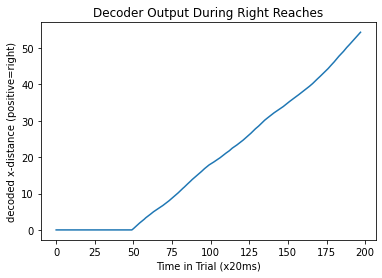

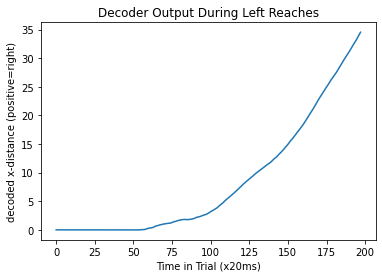

In [24]:
decoded_pos = decoder_trials
decoded_pos = np.array(decoded_pos)
decoded_right = decoded_pos[np.array(eeg_trial_labels)=='right']
decoded_left = decoded_pos[np.array(eeg_trial_labels)=='left']

plt.figure()
plt.plot(np.mean(decoded_right, axis=0))
plt.xlabel("Time in Trial (x20ms)")
plt.ylabel("decoded x-distance (positive=right)")
plt.title("Decoder Output During Right Reaches")

plt.figure()
plt.plot(np.mean(decoded_left, axis=0))
plt.xlabel("Time in Trial (x20ms)")
plt.ylabel("decoded x-distance (positive=right)")
plt.title("Decoder Output During Left Reaches")
plt.show()
